The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==0.13.2 -f https://d2l.ai/whl.html # installing d2l
!pip install -U mxnet-cu101mkl==1.6.0  # updating mxnet to at least v1.6


# Concise Implementation of Recurrent Neural Networks
:label:`sec_rnn_gluon`

While :numref:`sec_rnn_scratch` was instructive to see how recurrent neural networks (RNNs) are implemented, this is not convenient or fast. This section will show how to implement the same language model more efficiently using functions provided by Gluon. We begin as before by reading the "Time Machine" corpus.

In [1]:
from d2l import mxnet as d2l
from mxnet import np, npx
from mxnet.gluon import nn, rnn
npx.set_np()

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

## Defining the Model

Gluon's `rnn` module provides a recurrent neural network implementation (beyond many other sequence models). We construct the recurrent neural network layer `rnn_layer` with a single hidden layer and 256 hidden units, and initialize the weights.

In [2]:
num_hiddens = 256
rnn_layer = rnn.RNN(num_hiddens)
rnn_layer.initialize()

Initializing the state is straightforward. We invoke the member function `rnn_layer.begin_state(batch_size)`. This returns an initial state for each element in the minibatch. That is, it returns an object of size (hidden layers, batch size, number of hidden units). The number of hidden layers defaults to be 1. In fact, we have not even discussed yet what it means to have multiple layers---this will happen in :numref:`sec_deep_rnn`. For now, suffice it to say that multiple layers simply amount to the output of one RNN being used as the input for the next RNN.

In [3]:
batch_size = 1
state = rnn_layer.begin_state(batch_size=batch_size)
len(state), state[0].shape

(1, (1, 1, 256))

With a state variable and an input, we can compute the output with the updated state.

In [4]:
num_steps = 1
X = np.random.uniform(size=(num_steps, batch_size, len(vocab)))
Y, state_new = rnn_layer(X, state)
Y.shape, len(state_new), state_new[0].shape

((1, 1, 256), 1, (1, 1, 256))

Similar to :numref:`sec_rnn_scratch`, we define an `RNNModel` block by subclassing the `Block` class for a complete recurrent neural network. Note that `rnn_layer` only contains the hidden recurrent layers, we need to create a separate output layer. While in the previous section, we have the output layer within the `rnn` block.

In [5]:
#@save
class RNNModel(nn.Block):
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.dense = nn.Dense(vocab_size)

    def forward(self, inputs, state):
        X = npx.one_hot(inputs.T, self.vocab_size)
        Y, state = self.rnn(X, state)
        # The fully connected layer will first change the shape of Y to
        # (num_steps * batch_size, num_hiddens). Its output shape is
        # (num_steps * batch_size, vocab_size).
        output = self.dense(Y.reshape(-1, Y.shape[-1]))
        return output, state

    def begin_state(self, *args, **kwargs):
        return self.rnn.begin_state(*args, **kwargs)

## Training and Predicting

Before training the model, let us make a prediction with the a model that has random weights.

In [6]:
ctx = d2l.try_gpu()
model = RNNModel(rnn_layer, len(vocab))
model.initialize(force_reinit=True, ctx=ctx)
d2l.predict_ch8('time traveller', 10, model, vocab, ctx)

'time travellervmjznnngii'

As is quite obvious, this model does not work at all. Next, we call `train_ch8` with the same hyper-parameters defined in :numref:`sec_rnn_scratch` and train our model with Gluon.

Perplexity 1.2, 188616 tokens/sec on gpu(0)
time traveller came back and now the time traveller  you can sho
traveller  it wolld has of him was expounding this to the n


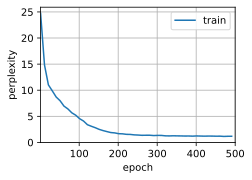

In [7]:
num_epochs, lr = 500, 1
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, ctx)

Compared with the last section, this model achieves comparable perplexity, albeit within a shorter period of time, due to the code being more optimized.

## Summary

* Gluon's `rnn` module provides an implementation at the recurrent neural network layer.
* Gluon's `nn.RNN` instance returns the output and hidden state after forward computation. This forward computation does not involve output layer computation.
* As before, the computational graph needs to be detached from previous steps for reasons of efficiency.

## Exercises

1. Compare the implementation with the previous section.
    * Why does Gluon's implementation run faster?
    * If you observe a significant difference beyond speed, try to find the reason.
1. Can you make the model overfit?
    * Increase the number of hidden units.
    * Increase the number of iterations.
    * What happens if you adjust the clipping parameter?
1. Implement the autoregressive model of the introduction to the current chapter using an RNN.
1. What happens if you increase the number of hidden layers in the RNN model? Can you make the model work?
1. How well can you compress the text using this model?
    * How many bits do you need?
    * Why does not everyone use this model for text compression? Hint: what about the compressor itself?

## [Discussions](https://discuss.mxnet.io/t/2365)

![](../img/qr_rnn-gluon.svg)